In [1]:
%cd /home/plent/Documenten/Gitlab/NeuralODEs/jax_neural_odes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import diffrax
import jax.numpy as jnp
import jax
import equinox as eqx
import optax
jax.config.update("jax_enable_x64", True)

/home/plent/Documenten/Gitlab/NeuralODEs/jax_neural_odes


### Modeling a glucose pulse in Saccharomyces.
Thanks to alot of work from olga we have a pytorch implementation of glycolysis. We will now build the model slightly different, with a matrix S and fluxes v, but the fluxes are defined very similarly to the pytorch project. Workflow
1. Start inspecting data. C1: For glucose_EC, we might need to interpolate. See how we can do this in diffrax.

In [2]:
glycolysis_data=pd.read_csv("datasets/VanHeerden_Glucose_Pulse/FF1_timeseries_format.csv",index_col=0).T
time_points=[int(i) for i in glycolysis_data.index.to_list()]




In [4]:


# %reload_ext autoreload
from source.kinetic_mechanisms.JaxKineticMechanisms import  *
from source.kinetic_mechanisms.JaxKineticMechanismsCustom import *
## set up a small term system for state variables
# S=pd.DataFrame(np.array([[-1,1,2]]),index=['ICglucose'],columns=['v_GLT','v_HXK','v_NTH1'])



# S=pd.DataFrame(np.array([[1,-1]]),index=['ICglucose'],columns=['v_GLT','v_HXK'])



GLT_params={'p_GLT_KmGLTGLCi':1.0078,'p_GLT_KmGLTGLCo':1.0078,'p_GLT_VmGLT':8.1327}
# HXK1_params={'p_HXK1_Kglc':0.3483,'p_HXK_Vmax':1 * 6.2548 *(1 + 0)}

HXK1_params={"p_HXK1_Kadp": 0.3492,"p_HXK1_Katp": 0.0931,
    "p_HXK1_Keq": 3.7213e+03,"p_HXK1_Kg6p": 34.7029,
    "p_HXK1_Kglc": 0.3483,"p_HXK1_Kt6p": 0.0073,"p_HXK_Vmax": 1 * 6.2548 * (1 + 0) }


NTH1_params={"p_NTH1_Ktre" : 2.1087,"p_NTH1_kcat" : 4.5132,"f_NTH1" : 0.0020,"p_NTH1_Vmax" : 4.5132 * 0.0020}


PGI_params={ "p_PGI1_Keq": 0.9564,"p_PGI1_Kf6p": 7.2433,"p_PGI1_Kg6p": 33.0689,'p_PGI1_Vmax':1*2.3215*1}



PGM1_params={"p_PGM1_Keq": 21.3955,"p_PGM1_Kg1p": 0.0653,"p_PGM1_Kg6p": 0.0324,"p_PGM1_Vmax":8.4574}
TPS1_params={ "p_TPS1_Kg6p": 4.5359,"p_TPS1_Kudp_glc": 0.1268,"p_TPS1_Kpi": 0.7890,"p_TPS1_KmF6P": 1.5631,"p_TPS1_Vmax":9.6164e+03*0.0014}
TPS2_params={"p_TPS2_Kt6p": 0.3686,"p_TPS2_Kpi": 0.7023,"p_TPS2_Vmax": 28.4097 * 0.0013}  # Calculated value for p_TPS2_Vmax
UGP_params={"f_UGP1":3.1000e-04}


PFK_params= {"p_PFK_Camp": 0.0287,"p_PFK_Catp": 1.2822,"p_PFK_Cf16bp": 2.3638,"p_PFK_Cf26bp": 0.0283,"p_PFK_Ciatp": 40.3824,"p_PFK_Kamp": 0.0100,
    "p_PFK_Katp": 1.9971,"p_PFK_Kf16bp": 0.0437,"p_PFK_Kf26bp": 0.0012,"p_PFK_Kf6p": 0.9166,"p_PFK_Kiatp": 4.9332,"p_PFK_L": 1.3886,
    "p_PFK_gR": 1.8127,"p_PFK_F26BP": 1e-3,"p_PFK_Vmax": 1 * 8.7826 * 1  # Calculated as p_PFK_ExprsCor * p_PFK_kcat * f_PFK
}

ALD_params = {
    "p_FBA1_Kdhap": 0.0300,"p_FBA1_Keq": 0.1223,"p_FBA1_Kf16bp": 0.6872,"p_FBA1_Kglyceral3p": 3.5582,"p_FBA1_Vmax": 4.4067 * 1}  # Calculated as p_FBA1_kcat * f_FBA1}



TPI1_params = {"p_TPI1_Kdhap": 205.9964,"p_TPI1_Keq": 0.0515,"p_TPI1_Kglyceral3p": 8.8483,"p_TPI1_Vmax":16.1694}


G3PDH_params = {"p_GPD1_Kadp": 1.1069,"p_GPD1_Katp": 0.5573,"p_GPD1_Kdhap": 2.7041,"p_GPD1_Keq": 1.0266e+04,
    "p_GPD1_Kf16bp": 12.7519,"p_GPD1_Kglyc3p": 3.2278,"p_GPD1_Knad": 0.6902,"p_GPD1_Knadh": 0.0322,"p_GPD1_Vmax": 1.7064 * 1}

PGK_params = {"p_PGK_KeqPGK": 3.2348e+03,"p_PGK_KmPGKADP": 0.2064,
    "p_PGK_KmPGKATP": 0.2859,"p_PGK_KmPGKBPG": 0.0031,"p_PGK_KmPGKP3G": 0.4759,
    "p_PGK_VmPGK": 55.1626,"p_PGK_ExprsCor": 1}


GAPDH_params = {
    "p_TDH1_Keq": 0.0054,"p_TDH1_Kglyceral3p": 4.5953,"p_TDH1_Kglycerate13bp": 0.9076,"p_TDH1_Knad": 1.1775,
    "p_TDH1_Knadh": 0.0419,"p_TDH1_Kpi": 0.7731,"p_GAPDH_Vmax": 1 * 78.6422 * (1 + 0 + 0)  # p_GAPDH_ExprsCor * p_TDH1_kcat * (f_TDH1 + f_TDH2 + f_TDH3)
}
vsink3PGA_params={"poly_sinkP3G" : 1e-03,"km_sinkP3G":0.007881000000000} #reverse the sink sign, otherwise it doesnt work

#MODELLING REACTION


HOR2_params = {
    "p_HOR2_Kglyc3p": 2.5844,
    "p_HOR2_Kpi": 2.5491,
    "p_HOR2_Vmax": 1.2748 * 1}

GlycT_params={"p_GlycerolTransport" : 0.1001,"f_GLYCEROL_e" : 0.1}

PGM_params = {
    "p_PGM_K2pg": 0.0750,"p_PGM_K3pg": 1.4151,"p_PGM_Keq": 0.1193,"p_PGM_Vm": 11.3652}

ENO1_params={"p_ENO1_K2pg": 0.0567,
    "p_ENO1_Keq": 4.3589,
    "p_ENO1_Kpep": 0.4831,
    "p_ENO1_Vm": 3.3018}




PYK1_params = {
    "p_PYK1_Kadp": 0.2430,"p_PYK1_Katp": 9.3000,"p_PYK1_Kf16bp": 0.1732,
    "p_PYK1_Kpep": 0.2810,"p_PYK1_L": 60000,
    "p_PYK1_hill": 4,"p_PYK1_Vm":9.3167}




PDC_params = {"p_PDC1_Kpi": 9.4294,"p_PDC1_Kpyr": 12.9680,
    "p_PDC1_hill": 0.7242,"p_PDC1_Vmax": 1 * 8.3613 * 0.5290  }
# }
ADH_params = {
    'p_ADH_KeqADH': 6.8487e-05,'p_ADH_KiADHACE': 0.6431,
    'p_ADH_KiADHETOH': 59.6935,'p_ADH_KiADHNAD': 0.9677,
    'p_ADH_KiADHNADH': 0.0316,'p_ADH_KmADHACE': 1.1322,
    'p_ADH_KmADHETOH': 4.8970,'p_ADH_KmADHNAD': 0.1534,
    'p_ADH_KmADHNADH': 0.1208,'p_ADH_VmADH': 13.2581,"p_ADH_ExprsCor":1}

#mitonadh
mitoNADH_params={"p_mitoNADHVmax":0.2401,"p_mitoNADHKm":1.0e-3}


vsinkPEP_params={"poly_sinkPEP":0.007607000000000,"km_sinkPEP":1e-03 } #reverse stoichiometry
vsinkACE_params={"poly_sinkACE": 0.034836166800000,"km_sinkACE":1e-04} #reverse stoichiometry
vsinkPYR_params={"poly_sinkPYR":0.161328300000000,"km_sinkPYR":1e-03} #reverse stoichiometry
vsink3PGA_params={"poly_sinkP3G" :0.007881000000000 ,"km_sinkP3G":1e-03} #reverse the sink sign, otherwise it doesnt work
v_sinkG6P_params={'poly_sinkG6P':0.077853600000000,'km_sinkG6P':1e-02} #reverse stoichiometry
v_sinkF6P_params={'poly_sinkF6P':0.024574614000000 ,'km_sinkF6P':1e-04}
v_sinkGAP={"poly_sinkGAP":0.012626,"km_sinkGAP":5e-04}
UGP_params={"flux_ugp":3.1000e-04}

ETOH_params={"p_kETOHtransport" : 0.0328,"f_ETOH_e" : 0}


params={**GLT_params,**HXK1_params,**NTH1_params,
        **NTH1_params,**PGI_params,**v_sinkG6P_params,
        **PGM1_params,**TPS1_params,**TPS2_params,
        **v_sinkF6P_params,**UGP_params,
        **PFK_params,**ALD_params,**v_sinkGAP,
        **TPI1_params,**G3PDH_params,
        **GAPDH_params,**PGK_params,**vsink3PGA_params,
        **HOR2_params,**GlycT_params,**PGM_params,
        **ENO1_params,**vsinkPEP_params,**vsinkPEP_params,
        **PYK1_params,**vsinkPYR_params,**PDC_params,**ADH_params,
        **vsinkACE_params,**ETOH_params,**mitoNADH_params,**UGP_params} #remove v_sinkF16P
print("n_parameters",len(params))

#interpolate things we do not wish to model    
coeffs_ECglucose=diffrax.backward_hermite_coefficients(ts=jnp.array(time_points),ys=jnp.array(glycolysis_data['ECglucose']),
                                             fill_forward_nans_at_end=True)
EC_glucose_interpolation_cubic=diffrax.CubicInterpolation(ts=jnp.array(time_points),coeffs=coeffs_ECglucose)
                                                    #  ys=EC_glucose_missing)

coeffs_ICtreh=diffrax.backward_hermite_coefficients(ts=jnp.array(time_points),ys=jnp.array(glycolysis_data['ICtreh']),
                                             fill_forward_nans_at_end=True)
ECtreh_interpolation_cubic=diffrax.CubicInterpolation(ts=jnp.array(time_points),coeffs=coeffs_ICtreh)                                                


coeffs_ICATP=diffrax.backward_hermite_coefficients(ts=jnp.array(time_points),ys=jnp.array(glycolysis_data['ICATP']),
                                             fill_forward_nans_at_end=True)
ICATP_interpolation_cubic=diffrax.CubicInterpolation(ts=jnp.array(time_points),coeffs=coeffs_ICATP)     

coeffs_ICADP=diffrax.backward_hermite_coefficients(ts=jnp.array(time_points),ys=jnp.array(glycolysis_data['ICADP']),
                                             fill_forward_nans_at_end=True)
ICADP_interpolation_cubic=diffrax.CubicInterpolation(ts=jnp.array(time_points),coeffs=coeffs_ICADP)     

coeffs_ICAMP=diffrax.backward_hermite_coefficients(ts=jnp.array(time_points),ys=jnp.array(glycolysis_data['ICAMP']),
                                             fill_forward_nans_at_end=True)
ICAMP_interpolation_cubic=diffrax.CubicInterpolation(ts=jnp.array(time_points),coeffs=coeffs_ICAMP)     


coeffs_ICPEP=diffrax.backward_hermite_coefficients(ts=jnp.array(time_points),ys=jnp.array(glycolysis_data['ICPEP']),
                                             fill_forward_nans_at_end=True)
ICPEP_interpolation_cubic=diffrax.CubicInterpolation(ts=jnp.array(time_points),coeffs=coeffs_ICPEP)  

##
v_GLT=Jax_Facilitated_Diffusion(substrate_extracellular='ECglucose',product_intracellular='ICglucose',vmax="p_GLT_VmGLT",km_internal='p_GLT_KmGLTGLCi',km_external='p_GLT_KmGLTGLCo')

v_HXK=Jax_Rev_BiBi_MM_w_Inhibition(substrate1='ICATP',substrate2="ICglucose",product1="ICADP",product2="ICATP",modifier="ICT6P",vmax="p_HXK_Vmax", k_equilibrium="p_HXK1_Keq", km_substrate1="p_HXK1_Katp", 
                                           km_substrate2="p_HXK1_Kglc",
                                           km_product1="p_HXK1_Kadp", km_product2="p_HXK1_Kg6p", ki_inhibitor="p_HXK1_Kt6p")



v_NTH1=Jax_Irrev_MM_Uni(substrate='ICtreh',vmax='p_NTH1_Vmax',km_substrate='p_NTH1_Ktre')
v_PGI=Jax_Rev_UniUni_MM(substrate='ICG6P',product='ICF6P',vmax='p_PGI1_Vmax',k_equilibrium='p_PGI1_Keq',km_substrate='p_PGI1_Kg6p',km_product='p_PGI1_Kf6p')
v_sinkG6P=Jax_MM_Sink(substrate='ICG6P',v_sink='poly_sinkG6P',km_sink='km_sinkG6P')
v_sinkF6P=Jax_MM_Sink(substrate='ICF6P',v_sink='poly_sinkF6P',km_sink='km_sinkF6P')
v_PGM1=Jax_Rev_UniUni_MM(substrate='ICG1P',product='ICG6P',vmax='p_PGM1_Vmax',k_equilibrium='p_PGM1_Keq',km_substrate='p_PGM1_Kg1p',km_product='p_PGM1_Kg6p') #to do v_TPS1 for 2nd rate law

# inhibitor_TPS1=SimpleInhibitor(k_I='p_TPS1_Kpi')
activator_TPS1=SimpleActivator(k_A="p_TPS1_KmF6P")
v_TPS1=Jax_Irrev_MM_Bi_w_Modifiers(substrate1="ICG6P",substrate2="ICG1P",modifiers_list=['ICF6P'],vmax="p_TPS1_Vmax",km_substrate1="p_TPS1_Kg6p",
                                  km_substrate2="p_TPS1_Kudp_glc",modifiers=[activator_TPS1])

# v_TPS1=Jax_Irrev_MM_Bi(substrate1="ICG6P",substrate2="ICG1P",vmax="p_TPS1_Vmax",km_substrate1="p_TPS1_Kg6p",km_substrate2="p_TPS1_Kudp_glc")
v_TPS2=Jax_Irrev_MM_Bi_w_Inhibition(substrate="ICT6P",product="ICPHOS",vmax="p_TPS2_Vmax", km_substrate1="p_TPS2_Kt6p", ki="p_TPS2_Kpi")



v_PFK=Jax_Specific(substrate1="ICF6P",substrate2="ICATP",product1="ICFBP",modifier="ICAMP",vmax="p_PFK_Vmax",kr_F6P="p_PFK_Kf6p", kr_ATP="p_PFK_Katp", gr="p_PFK_gR",c_ATP="p_PFK_Catp", ci_ATP="p_PFK_Ciatp", ci_AMP="p_PFK_Camp", 
                           ci_F26BP="p_PFK_Cf26bp", ci_F16BP="p_PFK_Cf16bp", l="p_PFK_L", 
                           kATP="p_PFK_Kiatp", kAMP="p_PFK_Kamp", F26BP ="p_PFK_F26BP",
                           kF26BP = "p_PFK_Kf26bp", kF16BP = "p_PFK_Kf16bp")
v_ALD=Jax_Rev_MM_UniBi(substrate='ICFBP',product1='ICGAP',product2='ICDHAP',vmax="p_FBA1_Vmax", k_equilibrium="p_FBA1_Keq", km_substrate="p_FBA1_Kf16bp",
                                    km_product1="p_FBA1_Kglyceral3p", km_product2="p_FBA1_Kdhap" )
v_TPI1=Jax_Rev_UniUni_MM(substrate="ICDHAP",product="ICGAP",vmax="p_TPI1_Vmax",k_equilibrium="p_TPI1_Keq", km_substrate="p_TPI1_Kdhap",
                                km_product="p_TPI1_Kglyceral3p")
v_sinkGAP=Jax_MM_Sink(substrate="ICGAP",v_sink="poly_sinkGAP",km_sink="km_sinkGAP")

v_G3PDH=Jax_Rev_BiBi_MM_w_Activation(substrate1="ICDHAP",substrate2="ICNADH",product1="ICG3P",product2="ICNAD",modifiers=['ICFBP', 'ICATP', 'ICADP'],vmax="p_GPD1_Vmax", k_equilibrium="p_GPD1_Keq", 
                                             km_substrate1="p_GPD1_Kdhap", km_substrate2="p_GPD1_Knadh",
                                             km_product1="p_GPD1_Kglyc3p", km_product2="p_GPD1_Knad",
                                               ka1="p_GPD1_Kf16bp", ka2="p_GPD1_Katp", ka3="p_GPD1_Kadp")




v_GAPDH=Jax_MM_Ordered_Bi_Tri(substrate1="ICGAP",substrate2="ICNAD",substrate3="ICPHOS",product1="ICBPG",product2="ICNADH",
                              vmax="p_GAPDH_Vmax", k_equilibrium="p_TDH1_Keq", km_substrate1="p_TDH1_Kglyceral3p",
                                      km_substrate2="p_TDH1_Knad", ki="p_TDH1_Kpi", 
                                      km_product1="p_TDH1_Kglycerate13bp", km_product2="p_TDH1_Knadh") #might exchange this mechanism by a BiBi mechanism, since modeling Phos is a bit too much



v_PGK=Jax_Rev_BiBi_MM(substrate1="ICBPG",substrate2="ICADP",product1="IC3PG",product2="ICATP",vmax="p_PGK_VmPGK",k_equilibrium="p_PGK_KeqPGK", 
                               km_substrate1="p_PGK_KmPGKBPG", km_substrate2="p_PGK_KmPGKADP", 
                               km_product1="p_PGK_KmPGKP3G", km_product2="p_PGK_KmPGKATP")


vsink3PGA=Jax_MM_Sink(substrate='IC3PG',v_sink='poly_sinkP3G',km_sink='km_sinkP3G')
#modeling reaction

# v_sinkDHAP=Jax_MM_Sink(substrate="ICDHAP",v_sink="poly_sinkDHAP",km_sink="km_sinkDHAP")

#hor2: might not be quite correct
HOR2_inhibition_Pi=SimpleInhibitor(k_I="p_HOR2_Kpi")
v_HOR2=Jax_Irrev_MM_Uni_w_Modifiers(substrate="ICG3P",vmax="p_HOR2_Vmax",km_substrate="p_HOR2_Kglyc3p",modifiers_list=["ICPHOS"],modifiers=[HOR2_inhibition_Pi])
v_GlycT=Jax_Diffusion(substrate="ICglyc",enzyme="f_GLYCEROL_e",transport_coef="p_GlycerolTransport")


v_PGM=Jax_Rev_UniUni_MM(substrate="IC3PG",product="IC2PG",vmax="p_PGM_Vm", k_equilibrium="p_PGM_Keq",
                                 km_substrate="p_PGM_K3pg", km_product="p_PGM_K2pg")

v_ENO=Jax_Rev_UniUni_MM(substrate="IC2PG",product="ICPEP",vmax="p_ENO1_Vm",k_equilibrium="p_ENO1_Keq",
                                km_substrate="p_ENO1_K2pg", km_product="p_ENO1_Kpep")

vsinkPEP = Jax_MM_Sink(substrate="ICPEP",v_sink="poly_sinkPEP", km_sink="km_sinkPEP") #reverse sign in stoichiometry

v_PYK1=Jax_Hill_Bi_Irreversible_Activation(substrate1="ICPEP",substrate2="ICADP",activator="ICFBP",product="ICATP",vmax="p_PYK1_Vm", hill="p_PYK1_hill",
                                                  k_substrate1="p_PYK1_Kpep", k_substrate2="p_PYK1_Kadp",
                                                  k_product="p_PYK1_Katp", k_activator="p_PYK1_Kf16bp", l="p_PYK1_L")

vsinkPYR=Jax_MM_Sink(substrate="ICPYR",v_sink="poly_sinkPYR", km_sink="km_sinkPYR")

v_PDC=Jax_Hill_Irreversible_Inhibition(substrate="ICPYR",inhibitor="ICPHOS",vmax="p_PDC1_Vmax",k_half_substrate="p_PDC1_Kpyr",
                                               hill="p_PDC1_hill", ki="p_PDC1_Kpi")



v_mitoNADH=Jax_MM(substrate="ICNADH",vmax="p_mitoNADHVmax",km="p_mitoNADHKm") #I think this can be replaced by Jax_Irrev_MM_Uni

# v_ADH=Jax_MM_Ordered_Bi_Bi(substrate1="ICNAD",substrate2="ICETOH",product1="ICACE",product2="ICNADH",
#                            vmax="p_ADH_VmADH", k_equilibrium="p_ADH_KeqADH", km_substrate1="p_ADH_KmADHNAD", km_substrate2="p_ADH_KmADHETOH",
#                                    km_product1="p_ADH_KmADHACE", km_product2="p_ADH_KmADHNADH", 
#                                    ki_substrate1="p_ADH_KiADHNAD", ki_substrate2="p_ADH_KiADHETOH", 
#                                    ki_product1="p_ADH_KiADHACE",ki_product2="p_ADH_KiADHNADH")

                #  NAD:str,
                #  ETOH:str,
                #  NADH:str,
                #  ACE:str,
v_ADH = Jax_ADH_Reaction(NAD="ICNAD",ETOH="ICETOH",NADH="ICNADH",ACE="ICACE",
    vmax='p_ADH_VmADH',
    k_equilibrium='p_ADH_KeqADH',km_substrate1='p_ADH_KiADHNAD',
    km_substrate2='p_ADH_KmADHETOH',km_product1='p_ADH_KmADHACE',
    km_product2='p_ADH_KmADHNADH',ki_substrate1='p_ADH_KiADHNAD',
    ki_substrate2='p_ADH_KiADHETOH',ki_product1='p_ADH_KiADHACE',
    ki_product2='p_ADH_KiADHNADH',exprs_cor="p_ADH_ExprsCor")



vsinkACE=Jax_MM_Sink(substrate="ICACE",v_sink="poly_sinkACE",km_sink="km_sinkACE")
v_EtohT = Jax_Diffusion(substrate="ICETOH",enzyme="f_ETOH_e", transport_coef="p_kETOHtransport")


n_parameters 131


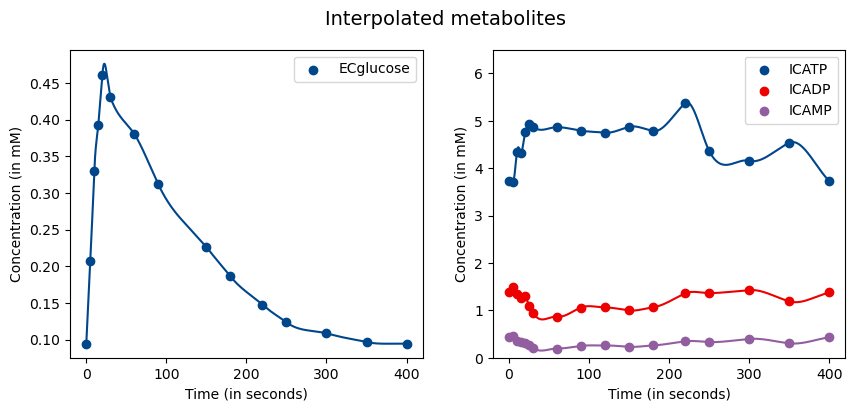

In [72]:
glycolysis_data=pd.read_csv("datasets/VanHeerden_Glucose_Pulse/FF1_timeseries_format.csv",index_col=0).T
time_points=[int(i) for i in glycolysis_data.index.to_list()]

fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(10,4))
ts=jnp.arange(0,400,0.01)

axs[0].scatter(time_points,glycolysis_data['ECglucose'],label="ECglucose",c="#00468BFF")
axs[0].plot(ts,EC_glucose_interpolation_cubic.evaluate(ts),c="#00468BFF")

axs[1].scatter(time_points,glycolysis_data['ICATP'],label="ICATP",c="#00468BFF")
axs[1].scatter(time_points,glycolysis_data['ICADP'],label="ICADP",c="#ED0000FF")
axs[1].scatter(time_points,glycolysis_data['ICAMP'],label="ICAMP",c="#925E9FFF")

axs[1].plot(ts,ICATP_interpolation_cubic.evaluate(ts),c="#00468BFF")
axs[1].plot(ts,ICADP_interpolation_cubic.evaluate(ts),c="#ED0000FF")
axs[1].plot(ts,ICAMP_interpolation_cubic.evaluate(ts),c="#925E9FFF")

axs[1].set_xlabel("Time (in seconds)")
axs[1].set_ylabel("Concentration (in mM)")
axs[0].set_ylabel("Concentration (in mM)")
axs[0].set_xlabel("Time (in seconds)")
axs[1].set_ylim(0,6.5)

axs[1].legend( loc='upper right')
axs[0].legend(loc='upper right')
fig.suptitle("Interpolated metabolites", fontsize=14)
fig.savefig("figures/interpolated_metabolites.svg")
fig.savefig("figures/interpolated_metabolites.png")


In [5]:
class glycolysis():
    def __init__(self,
                  interpolate_dict:dict,
                  met_names:list):
       self.interpolate_dict=interpolate_dict
       self.met_names=met_names

    def __call__(self,t,y,args):
        
        params=args


        y=dict(zip(self.met_names,y))


        y['ECglucose']=self.interpolate_dict['ECglucose'].evaluate(t)
        # y['ICtreh']=self.interpolate_dict['ICtreh'].evaluate(t)
        # y['ICPEP']=self.interpolate_dict['ICPEP'].evaluate(t)
        y['ICATP']=self.interpolate_dict['ICATP'].evaluate(t)
        y['ICADP']=self.interpolate_dict['ICADP'].evaluate(t)
        y['ICAMP']=self.interpolate_dict['ICAMP'].evaluate(t)


        y['ICPHOS']=10




        eval_dict={**y,**params}
        #modifiers and stuff
        # eval_dict['ICPHOS']

        rate_vGLT=v_GLT(eval_dict)
        rate_vHXK=v_HXK(eval_dict)
        rate_vNTH1=v_NTH1(eval_dict)
        rate_vPGI=v_PGI(eval_dict)

        rate_vsinkG6P=v_sinkG6P(eval_dict)
        rate_vsinkF6P=v_sinkF6P(eval_dict)
        rate_vPGM1=v_PGM1(eval_dict)
        rate_vTPS1=v_TPS1(eval_dict)
        rate_vTPS2=v_TPS2(eval_dict)
        rate_vPFK=v_PFK(eval_dict)
        rate_vALD=v_ALD(eval_dict)

        rate_TPI1=v_TPI1(eval_dict)
        rate_GP3DH=v_G3PDH(eval_dict)
        rate_PGK=v_PGK(eval_dict)
        rate_vsinkGAP=v_sinkGAP(eval_dict)
        rate_GAPDH=v_GAPDH(eval_dict)
        rate_vsink3PGA=vsink3PGA(eval_dict)
        rate_HOR2=v_HOR2(eval_dict)
        rate_vGLycT=v_GlycT(eval_dict)
        rate_PGM=v_PGM(eval_dict)
        rate_ENO=v_ENO(eval_dict)
        rate_vsinkPEP=vsinkPEP(eval_dict)
        rate_PYK1=v_PYK1(eval_dict)
        rate_vsinkPYR=vsinkPYR(eval_dict)
        rate_vPDC=v_PDC(eval_dict)
        rate_ADH=v_ADH(eval_dict)
        rate_vsinkACE=vsinkACE(eval_dict)
        rate_ETOH_transport=v_EtohT(eval_dict)
        rate_vmitoNADH=v_mitoNADH(eval_dict)
        #modeling rates: checking
        # dATP=

        dG1P=-rate_vPGM1-params['flux_ugp']
        dT6P=+rate_vTPS1 -rate_vTPS2
        dICTRE=+rate_vTPS2 -rate_vNTH1
        

        dICglci=+rate_vGLT - rate_vHXK +2*rate_vNTH1

        dICG6P=+rate_vHXK-rate_vPGI -rate_vsinkG6P +rate_vPGM1-rate_vTPS1#we reverse the direction of the sink, since in logspace parameters cannot be negative
        dICF6P=+rate_vPGI +rate_vsinkF6P-rate_vPFK
        dICFBP=+rate_vPFK -rate_vALD

        dICDHAP=+rate_vALD - rate_TPI1 - rate_GP3DH #modelling reaction rate_vsinkDHAP
        dICG3P=+rate_GP3DH-rate_HOR2
        dICGlyc=+rate_HOR2#-rate_vGLycT

        dICGAP=+rate_vALD +rate_TPI1  -rate_GAPDH +rate_vsinkGAP
        dICBPG=+rate_GAPDH -rate_PGK
        dIC3PG=+rate_PGK - rate_vsink3PGA -rate_PGM#reverse the sign of vsink3PGA, it had a negative value, but we do not allow negative parameters
        dIC2PG=+rate_PGM-rate_ENO
        # dIC2PG=0
        dICPEP=+rate_ENO -rate_vsinkPEP-rate_PYK1 
        
        dICPYR= +rate_PYK1 -rate_vPDC -rate_vsinkPYR 
        
        dICACE= +rate_vPDC -rate_ADH -rate_vsinkACE

        dICETOH=+rate_ADH -rate_ETOH_transport

        #so it turns out G3PDH is the problematic one
        dICNAD=+rate_GP3DH -rate_GAPDH   +rate_ADH +rate_vmitoNADH 
        dICNADH=-rate_GP3DH +rate_GAPDH   -rate_ADH -rate_vmitoNADH
        #rate_vmitoNADH is fine,


        return jnp.stack([dG1P,dT6P,dICTRE,dICglci,dICG6P,dICF6P,
                          dICFBP,dICDHAP,dICG3P,
                          dICGlyc,dICGAP,dICBPG,dIC3PG,
                          dIC2PG,dICPEP,dICPYR,dICACE,dICETOH,dICNADH,dICNAD])#,dICPEP,dICPYR,dICACE])


interpolated_mets={'ECglucose':EC_glucose_interpolation_cubic,
                    'ICtreh':ECtreh_interpolation_cubic,
                    "ICATP":ICATP_interpolation_cubic,
                    "ICADP":ICADP_interpolation_cubic,
                    "ICAMP":ICAMP_interpolation_cubic,
                    "ICPEP":ICPEP_interpolation_cubic}





y0_dict={'ICG1P':0.064568,
         "ICT6P":0.093705,
         "ICtreh":63.312040,
         'ICglucose':0.196003,
         'ICG6P':0.716385,
         'ICF6P':0.202293,
         "ICFBP":0.057001,
         "ICDHAP":0.048571,
         "ICG3P":0.020586,
         "ICglyc":0.1,
         "ICGAP":0.006213,
         "ICBPG":0.0001,
         "IC3PG":2.311074,
         "IC2PG":0.297534,
          "ICPEP":1.171415,
          "ICPYR":0.152195,
          "ICACE":0.04,
          "ICETOH":10.0,
          "ICNADH":0.0106,
          "ICNAD":1.5794}
        #  ICPYR":0.152195,
        #  "ICACE":0.04}


y0=jnp.array(list(y0_dict.values()))
metabolite_names=list(y0_dict.keys())

glycolyse=glycolysis(interpolated_mets,metabolite_names)
term=diffrax.ODETerm(glycolyse)

ts=jnp.linspace(0,400,1000)

solver = diffrax.Kvaerno5()
saveat=diffrax.SaveAt(ts=ts)
stepsize_controller = diffrax.PIDController(rtol=1e-6, atol=1e-9)


sol = diffrax.diffeqsolve(term, solver, t0=ts[0], t1=ts[-1], 
                          dt0=0.01, 
                          y0=y0,
                          saveat=saveat,
                            stepsize_controller=stepsize_controller,
                            args=params,
                            max_steps=200000)



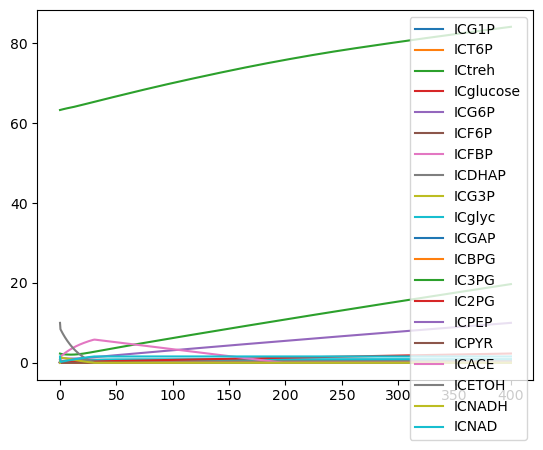

In [6]:
metabolite_names=glycolyse.met_names

ys_df=pd.DataFrame(sol.ys,index=sol.ts,columns=metabolite_names)

# met_names=["ICtreh","ICG1P"]
# met_names=['ICNADH',"ICNAD"]


for met in metabolite_names:
    plt.plot(list(ys_df.index),ys_df[met],label=met)
    # try:
    #     plt.scatter(time_points,glycolysis_data[met])
    # except:
    #     continue

# plt.plot(new_ts,EC_glucose_interpolation_cubic.evaluate(t0=new_ts),label="cubic interpolation")
# plt.plot(new_ts,ECtreh_interpolation_cubic.evaluate(t0=new_ts),label="cubic interpolation")
# plt.scatter(time_points,glycolysis_data['ICglucose'],label="true data ICgluc",c="red")
# plt.scatter(time_points,glycolysis_data['ICG6P'],label="true data ICgluc",c="red")
# plt.scatter(time_points,glycolysis_data['ICG6P'],label="true data ICG6P",c="blue")
# plt.scatter(time_points,glycolysis_data['ICF6P'],label="true data ICF6P",c="green")
# plt.scatter(time_points,glycolysis_data['ICFBP'],label="true data ICFBP",c="black")
# plt.scatter(time_points,glycolysis_data['ICGAP'],label="true data ICGAP",c="grey")
# plt.scatter(time_points,glycolysis_data['ICG1P'],label="true data ICPYR",c="orange")
# plt.scatter(time_points,glycolysis_data['ICtreh'],label="true data ICPEP",c="turquoise")
plt.legend()
# plt.yscale("log")

In [7]:
# log_loss_func=jax.jit(create_log_params_log_loss_func(JaxKmodel))
from source.parameter_estimation.training import *


class NeuralODE():
    def __init__(self,func):

        self.func=func
        self.rtol=1e-8
        self.atol=1e-11
        self.max_steps=200000
        
    def __call__(self,ts,y0,params):
        solution = diffrax.diffeqsolve(
        diffrax.ODETerm(self.func),
        diffrax.Kvaerno5(),
        t0=ts[0],
        t1=ts[-1],
        dt0=1e-10,
        y0=y0,
        args=(params),
        stepsize_controller=diffrax.PIDController(rtol=self.rtol, atol=self.atol,pcoeff=0.4,icoeff=0.3,dcoeff=0),
        saveat=diffrax.SaveAt(ts=ts),
        max_steps=self.max_steps)

        return solution.ys


glycolyse=jax.jit(NeuralODE(glycolysis(interpolated_mets,metabolite_names)))



In [77]:
# def create_log_params_loss_func(model,to_include:list):
#     """Loss function for log transformed parameters """
#     def loss_func(params,ts,ys):
#         params=exponentiate_parameters(params)
#         mask=~jnp.isnan(jnp.array(ys))
#         ys=jnp.atleast_2d(ys)
#         y0=ys[0,:]
#         y_pred=model(ts,y0,params)
#         ys = jnp.where(mask, ys, 0)
#         y_pred = jnp.where(mask, y_pred, 0)
    
#         ys=ys[:,to_include]
#         y_pred=y_pred[:,to_include]

#         non_nan_count = jnp.sum(mask)
        
#         loss = jnp.sum((y_pred - ys) ** 2) / non_nan_count
#         return loss
#     return loss_func


In [78]:
len(metabolite_names)
metabolite_names[15]

'ICPYR'

In [8]:

def create_log_params_means_centered_loss_func(model,to_include:list):
    """Loss function for log transformed parameters. 
    We do a simple input scaling using the mean per state variable (we add 1 everywhere to prevent division by zero) """
    def loss_func(params,ts,ys):

        params=exponentiate_parameters(params)
        mask=~jnp.isnan(jnp.array(ys))
        ys=jnp.atleast_2d(ys)
        y0=ys[0,:]
        y_pred=model(ts,y0,params)
        ys = jnp.where(mask, ys, 0)

        ys=ys+1
        y_pred=y_pred+1
        scale=jnp.mean(ys,axis=0)

        ys=ys/scale
        y_pred=y_pred/scale

        y_pred = jnp.where(mask, y_pred, 0)


            
        ys=ys[:,to_include]
        y_pred=y_pred[:,to_include]
        # print(ys,y_pred)
        non_nan_count = jnp.sum(mask)

        loss = jnp.sum((y_pred - ys) ** 2) / non_nan_count
        return loss
    return loss_func




log_loss_func=jax.jit(create_log_params_means_centered_loss_func(glycolyse,[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]))
# loss_func=jax.jit(create_loss_func(glycolyse))


@jax.jit
def update_log(opt_state,params,ts,ys):
    """Update rule for the gradients for log-transformed parameters. Can only be applied
    to nonnegative parameters"""
    log_params=log_transform_parameters(params)
    loss=log_loss_func(log_params,ts,ys)
    # print(loss)
    grads=jax.jit(jax.grad(log_loss_func,0))(log_params,ts,ys) #loss w.r.t. parameters
    updates,opt_state=optimizer.update(grads,opt_state)
    #we perform updates in log space, but only return params in lin space
    log_params = optax.apply_updates(log_params, updates)
    lin_params = exponentiate_parameters(log_params) 
    return opt_state,lin_params,loss,grads

# loss_func(params,time_points,jnp.array(glycolysis_data[['ICglucose','ICG6P']]))
glycolysis_data.loc["0",'ICglyc']=0.01
# glycolysis_data.loc[:,'ICBPG']=np.nan
glycolysis_data.loc["0",'ICBPG']=0.0001
glycolysis_data.loc["0",'ICNAD']=1.5794
glycolysis_data.loc["0",'ICNADH']=0.0106
glycolysis_data.loc["0","ICACE"]=0.04
glycolysis_data.loc["0","ICETOH"]=10.0
# print(glycolysis_data[met_names])

dataset=glycolysis_data[metabolite_names]
dataset=jnp.array(dataset)

# np.where(dataset[0,:]-y0>0.001)[0]
log_loss_func(params,time_points,dataset)
# met_names[11]


Array(773.04845794, dtype=float64)

In [80]:
# params_init=params
# lr=1e-3
# optimizer = optax.adabelief(lr)
# clip_by_global=optax.clip_by_global_norm(np.log(4))
# optimizer = optax.chain(optimizer,clip_by_global)
# opt_state = optimizer.init(params_init)

# opt_state,params_init,loss,grads=update_log(opt_state,params_init,time_points,
#                                             jnp.array(glycolysis_data[met_names]))

In [32]:
# met_names=['ICG1P',"ICT6P","ICtreh",'ICglucose','ICG6P','ICF6P',"ICFBP","ICDHAP","ICG3P","ICglyc","ICGAP","ICBPG","IC3PG","IC2PG","ICPEP","ICPYR",'ICNADH',"ICNAD"]
# params_init=params
lr=1e-3
optimizer = optax.adabelief(lr)
clip_by_global=optax.clip_by_global_norm(np.log(4))
optimizer = optax.chain(optimizer,clip_by_global)
opt_state = optimizer.init(params_init)

loss_per_iter=[]
print("round 3")
params_per_iter=[]
# alpha1=np.linspace(0.2,1.0,2500)
for step in range(500):
    opt_state,params_init,loss,grads=update_log(opt_state,params_init,time_points,
                                                jnp.array(glycolysis_data[metabolite_names]))
    
    loss_per_iter.append(float(loss))
    if step% 50==0:
        
#           # Scale step to range [0, 1]
        params_per_iter.append(params_init)
        print(f"global norm: {global_norm(grads)}")
        print(f"Step {step}, Loss {loss}")




#0.1449

# for step in range(1000):
#     opt_state,params_init2,loss,grads=update_log(opt_state,params_init2,time_points[0:7],jnp.array(glycolysis_data['ICglucose'])[0:3])
#     print(loss)

round 3
global norm: 0.00048729223813580937
Step 0, Loss 0.13200430884207642
global norm: 0.0010051262812105066
Step 50, Loss 0.13200390347229923
global norm: 0.0024674021163500854
Step 100, Loss 0.1319990361995221
global norm: 0.0007772450531542212
Step 150, Loss 0.13199753435135517
global norm: 0.00112063058470821
Step 200, Loss 0.13199606276684256
global norm: 0.00042188760938679864
Step 250, Loss 0.13199233443658606
global norm: 0.0011529749021063898
Step 300, Loss 0.1319926248058499
global norm: 0.0008455902286707021
Step 350, Loss 0.13198931375006331
global norm: 0.0004801713012597737
Step 400, Loss 0.13198660316189034
global norm: 0.0009309657484990539
Step 450, Loss 0.13198597294063902


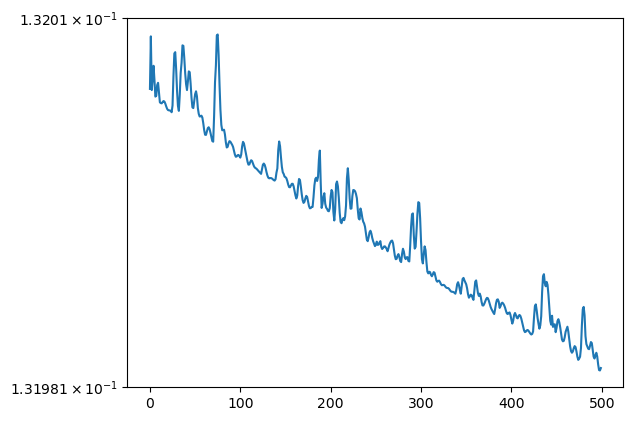

In [33]:
plt.plot(loss_per_iter[:])
plt.yscale("symlog")
# plt.ylim(0,0.3)

#100 iterations at a time
#0.18723806351094247
#0.15038772771936695
#0.14044019529771518
#0.1370887704597411
#0.13572529656512045
#0.1341637029797895
#0.1325
#0.13231860395120204
params_saved=params_init

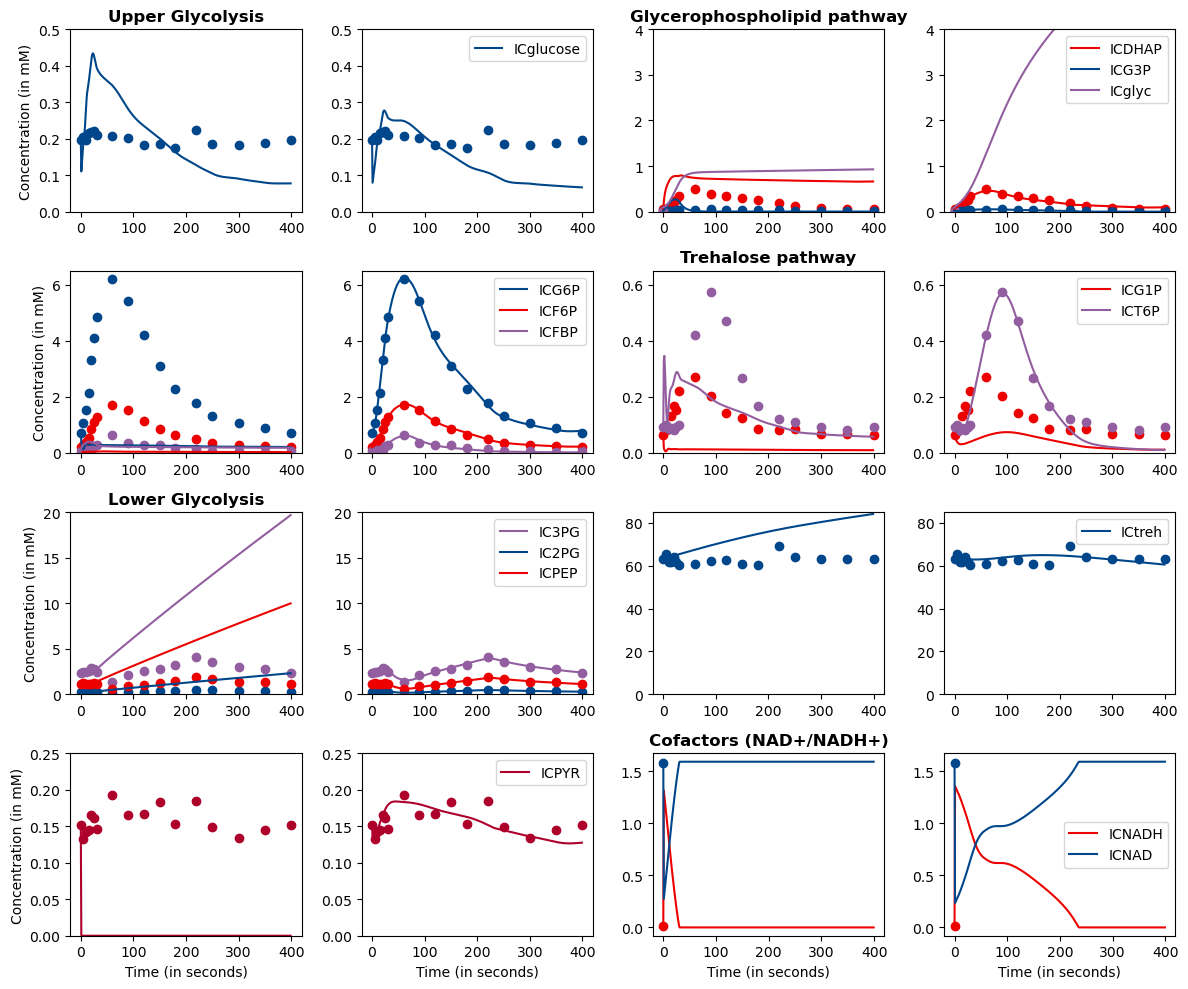

In [53]:
ts=jnp.arange(0,400,1)
ys_after_training=glycolyse(ts,y0,params_init)
ys_after_training=pd.DataFrame(ys_after_training,columns=metabolite_names,index=ts)

ys_before_training=glycolyse(ts,y0,params)
ys_before_training=pd.DataFrame(ys_before_training,columns=metabolite_names,index=ts)

fig,axs=plt.subplots(nrows=4,ncols=4,figsize=(12,10))


axs[0, 0].set_title("Upper Glycolysis",loc="center",fontdict={"fontweight":"bold"})
axs[0, 2].set_title("Glycerophospholipid pathway",loc="center",fontdict={"fontweight":"bold"})
axs[2, 0].set_title("Lower Glycolysis",loc="center",fontdict={"fontweight":"bold"})
axs[1, 2].set_title("Trehalose pathway",loc="center",fontdict={"fontweight":"bold"})
axs[3, 2].set_title("Cofactors (NAD+/NADH+)",loc="center",fontdict={"fontweight":"bold"})
# fig.text(0.5,0.93,"Upper Glycolysis",ha="center",va="center",fontsize=14)

met_names=["ICglucose"]
for metabolite in met_names:
    axs[0,0].plot(ts,ys_before_training[metabolite],label=metabolite,c="#00468BFF")
    axs[0,0].scatter(time_points,glycolysis_data[metabolite],c="#00468BFF")
    axs[0,1].plot(ts,ys_after_training[metabolite],label=metabolite,c="#00468BFF")
    axs[0,1].scatter(time_points,glycolysis_data[metabolite],c="#00468BFF")
    axs[0,1].legend()
    axs[0,1].set_ylim(0,0.5)
    axs[0,0].set_ylim(0,0.5)



met_names=["ICG6P","ICF6P","ICFBP"]
colors={"ICF6P":"#ED0000FF","ICG6P":"#00468BFF","ICFBP":"#925E9FFF"}
for metabolite in met_names:
    axs[1,0].plot(ts,ys_before_training[metabolite],label=metabolite,c=colors[metabolite])
    axs[1,0].scatter(time_points,glycolysis_data[metabolite],c=colors[metabolite])
    axs[1,1].plot(ts,ys_after_training[metabolite],label=metabolite,c=colors[metabolite])
    axs[1,1].scatter(time_points,glycolysis_data[metabolite],c=colors[metabolite])
    axs[1,1].legend()
    axs[1,1].set_ylim(0,6.5)
    axs[1,0].set_ylim(0,6.5)

met_names=["IC3PG","IC2PG","ICPEP"]
colors={"ICPEP":"#ED0000FF","IC2PG":"#00468BFF","IC3PG":"#925E9FFF"}
for metabolite in met_names:
    axs[2,0].plot(ts,ys_before_training[metabolite],label=metabolite,c=colors[metabolite])
    axs[2,0].scatter(time_points,glycolysis_data[metabolite],c=colors[metabolite])
    axs[2,1].plot(ts,ys_after_training[metabolite],label=metabolite,c=colors[metabolite])
    axs[2,1].scatter(time_points,glycolysis_data[metabolite],c=colors[metabolite])
    axs[2,1].legend()
    axs[2,1].set_ylim(0,20)
    axs[2,0].set_ylim(0,20)
    

met_names=["ICPYR"]
for metabolite in met_names:
    axs[3,0].plot(ts,ys_before_training[metabolite],label=metabolite,c="#AD002AFF")
    axs[3,0].scatter(time_points,glycolysis_data[metabolite],c="#AD002AFF")
    axs[3,1].plot(ts,ys_after_training[metabolite],label=metabolite,c="#AD002AFF")
    axs[3,1].scatter(time_points,glycolysis_data[metabolite],c="#AD002AFF")
    axs[3,1].legend()
    axs[3,1].set_ylim(0,0.25)
    axs[3,0].set_ylim(0,0.25)


met_names=["ICDHAP","ICG3P","ICglyc"]
colors={"ICDHAP":"#ED0000FF","ICG3P":"#00468BFF","ICglyc":"#925E9FFF"}
for metabolite in met_names:
    axs[0,2].plot(ts,ys_before_training[metabolite],label=metabolite,c=colors[metabolite])
    axs[0,2].scatter(time_points,glycolysis_data[metabolite],c=colors[metabolite])
    axs[0,3].plot(ts,ys_after_training[metabolite],label=metabolite,c=colors[metabolite])
    axs[0,3].scatter(time_points,glycolysis_data[metabolite],c=colors[metabolite])
    axs[0,3].legend()
    axs[0,2].set_ylim(0,4)
    axs[0,3].set_ylim(0,4)

met_names=["ICG1P","ICT6P"]#,"ICtreh","ICT6P"]
colors={"ICG1P":"#ED0000FF","ICtreh":"#00468BFF","ICT6P":"#925E9FFF"}
for metabolite in met_names:
    axs[1,2].plot(ts,ys_before_training[metabolite],label=metabolite,c=colors[metabolite])
    axs[1,2].scatter(time_points,glycolysis_data[metabolite],c=colors[metabolite])
    axs[1,3].plot(ts,ys_after_training[metabolite],label=metabolite,c=colors[metabolite])
    axs[1,3].scatter(time_points,glycolysis_data[metabolite],c=colors[metabolite])
    axs[1,3].legend()
    axs[1,2].set_ylim(0,0.65)
    axs[1,3].set_ylim(0,0.65)

met_names=["ICtreh"]#,"ICtreh","ICT6P"]
colors={"ICG1P":"#ED0000FF","ICtreh":"#00468BFF","ICT6P":"#925E9FFF"}
for metabolite in met_names:
    axs[2,2].plot(ts,ys_before_training[metabolite],label=metabolite,c=colors[metabolite])
    axs[2,2].scatter(time_points,glycolysis_data[metabolite],c=colors[metabolite])
    axs[2,3].plot(ts,ys_after_training[metabolite],label=metabolite,c=colors[metabolite])
    axs[2,3].scatter(time_points,glycolysis_data[metabolite],c=colors[metabolite])
    axs[2,3].legend()
    axs[2,2].set_ylim(0,85)
    axs[2,3].set_ylim(0,85)


met_names=["ICNADH","ICNAD"]#,"ICtreh","ICT6P"]
colors={"ICNADH":"#ED0000FF","ICNAD":"#00468BFF","ICT6P":"#925E9FFF"}
for metabolite in met_names:
    axs[3,2].plot(ts,ys_before_training[metabolite],label=metabolite,c=colors[metabolite])
    axs[3,2].scatter(time_points,glycolysis_data[metabolite],c=colors[metabolite])
    axs[3,3].plot(ts,ys_after_training[metabolite],label=metabolite,c=colors[metabolite])
    axs[3,3].scatter(time_points,glycolysis_data[metabolite],c=colors[metabolite])
    axs[3,3].legend()
    # axs[3,2].set_ylim(0,85)
    # axs[3,3].set_ylim(0,85)

axs[3,0].set_xlabel("Time (in seconds)")
axs[3,1].set_xlabel("Time (in seconds)")
axs[3,2].set_xlabel("Time (in seconds)")
axs[3,3].set_xlabel("Time (in seconds)")
axs[0,0].set_ylabel("Concentration (in mM)")
axs[1,0].set_ylabel("Concentration (in mM)")
axs[2,0].set_ylabel("Concentration (in mM)")
axs[3,0].set_ylabel("Concentration (in mM)")
fig.tight_layout()

# fig.savefig("figures/figures_glycolysis/fitted_metabolites.png")
# fig.savefig("figures/figures_glycolysis/fitted_metabolites.svg")


In [57]:
parameters_after_training=pd.DataFrame(pd.Series(params_saved),columns=["Trained_Parameters"])
parameters_after_training['Initialized_Parameters']=params
parameters_after_training.to_csv("results/EXP3_Glycolysis/1508_parameters_glucosepulse1.csv")